In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
import os
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

In [2]:
def load_dataset(filename):
  df = pd.read_csv(filename)
  label = df["label"]
  unique_label = list(set(label))
  sentences = list(df["text"])
  
  return (df, label, unique_label, sentences)

In [3]:
df, label, unique_label, sentences = load_dataset('C:/Users/savan/Downloads/datasets/iseardataset.csv')

In [4]:
print(unique_label)

['anger', 'joy', 'disgust', 'fear', 'guilt', 'sadness', 'shame']


In [5]:
print(df.head(10))

     label                                               text Unnamed: 2
0      joy  On days when I feel close to my partner and ot...        NaN
1     fear  Every time I imagine that someone I love or I ...        NaN
2    anger  When I had been obviously unjustly treated and...        NaN
3  sadness  When I think about the short time that we live...        NaN
4  disgust  At a gathering I found myself involuntarily si...        NaN
5    shame  When I realized that I was directing the feeli...        NaN
6    guilt  I feel guilty when when I realize that I consi...        NaN
7      joy  After my girlfriend had taken her exam we went...        NaN
8     fear  When, for the first time I realized the meanin...        NaN
9    anger  When a car is overtaking another and I am forc...        NaN


In [6]:
#define stemmer
stemmer = LancasterStemmer()

In [7]:
def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    words.append([i.lower() for i in w])
    
  return words 

In [8]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  

7516
[['on', 'days', 'when', 'i', 'feel', 'close', 'to', 'my', 'partner', 'and', 'other', 'friends', 'when', 'i', 'feel', 'at', 'peace', 'with', 'myself', 'and', 'also', 'experience', 'a', 'close', 'contact', 'with', 'people', 'whom', 'i', 'regard', 'greatly'], ['every', 'time', 'i', 'imagine', 'that', 'someone', 'i', 'love', 'or', 'i', 'could', 'contact', 'a', 'serious', 'illness', 'even', 'death']]


In [9]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [10]:
def max_length(words):
  return(len(max(words, key = len)))

In [11]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 8989 and Maximum length = 179


In [12]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [13]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [14]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [15]:
padded_doc = padding_doc(encoded_doc, max_length)

In [16]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (7516, 179)


In [17]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_label, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [18]:
output_tokenizer.word_index

{'anger': 1,
 'joy': 2,
 'disgust': 3,
 'fear': 4,
 'guilt': 5,
 'sadness': 6,
 'shame': 7}

In [19]:
encoded_output = encoding_doc(output_tokenizer, label)

In [20]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [21]:
encoded_output.shape

(7516, 1)

In [22]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [23]:
output_one_hot = one_hot(encoded_output)

In [24]:
output_one_hot.shape

(7516, 7)

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

In [27]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (6012, 179) and train_Y = (6012, 7)
Shape of val_X = (1504, 179) and val_Y = (1504, 7)


In [28]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(GRU(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation = "softmax"))
  
  return model

In [29]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 179, 128)          1150592   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              198144    
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 1,357,191
Trainable params: 206,599
Non-trainable params: 1,150,592
________________________________________

In [30]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

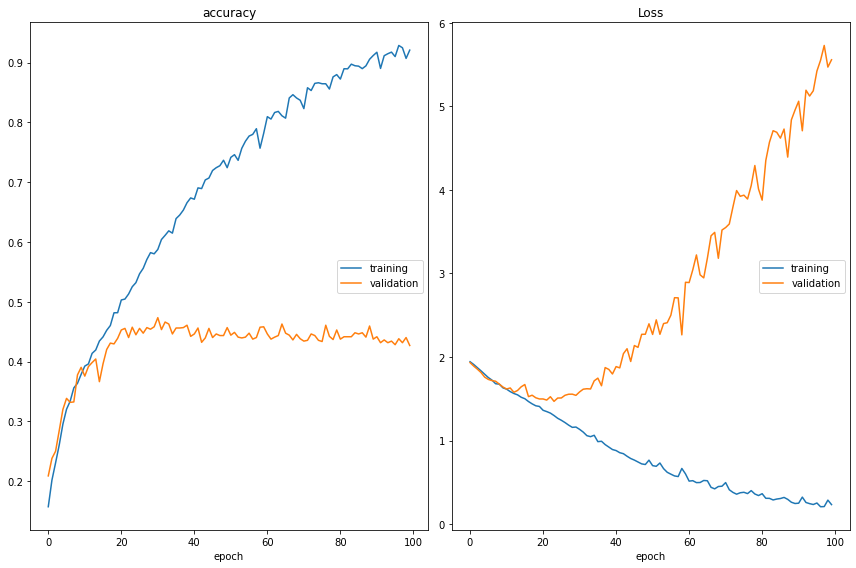

accuracy
	training         	 (min:    0.157, max:    0.929, cur:    0.921)
	validation       	 (min:    0.209, max:    0.473, cur:    0.427)
Loss
	training         	 (min:    0.207, max:    1.944, cur:    0.233)
	validation       	 (min:    1.469, max:    5.730, cur:    5.559)

Epoch 00100: val_loss did not improve from 1.46917
188/188 [==============================] - 44s 234ms/step - loss: 0.2330 - accuracy: 0.9208 - val_loss: 5.5590 - val_accuracy: 0.4269


In [31]:
hist = model.fit(train_X, train_Y,
                 epochs = 100,
                 batch_size = 32,
                 validation_data = (val_X, val_Y),
                 callbacks = [PlotLossesKeras(), checkpoint])

In [32]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation = "softmax"))
  
  return model

model_lstm = create_model(vocab_size, max_length)

model_lstm.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 179, 128)          1150592   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 7)                 231       
                                                                 
Total params: 1,422,215
Trainable params: 271,623
Non-trainable params: 1,150,592
______________________________________

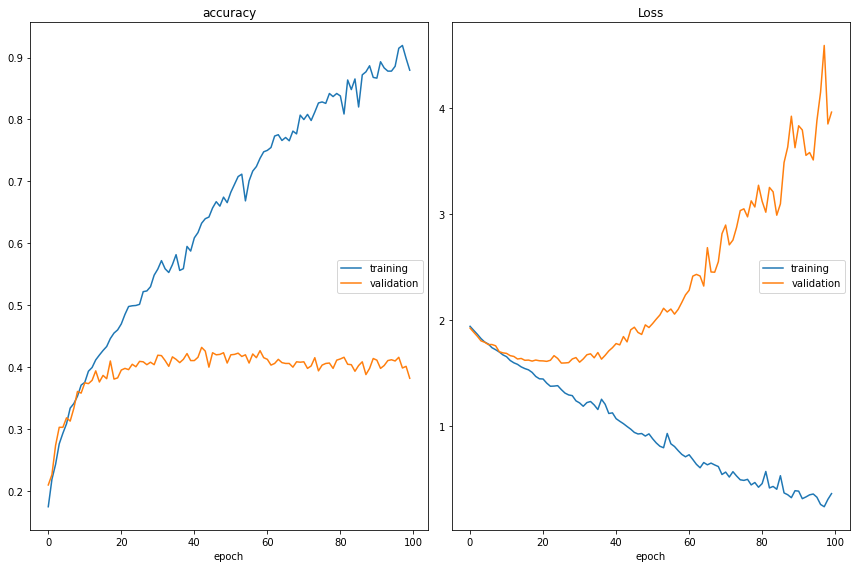

accuracy
	training         	 (min:    0.175, max:    0.919, cur:    0.880)
	validation       	 (min:    0.210, max:    0.432, cur:    0.382)
Loss
	training         	 (min:    0.237, max:    1.939, cur:    0.361)
	validation       	 (min:    1.592, max:    4.588, cur:    3.959)

Epoch 00100: val_loss did not improve from 1.59189
188/188 [==============================] - 38s 204ms/step - loss: 0.3608 - accuracy: 0.8796 - val_loss: 3.9589 - val_accuracy: 0.3823


In [33]:
filename = 'model_lstm.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

hist = model_lstm.fit(train_X, train_Y,
                 epochs = 100,
                 batch_size = 32,
                 validation_data = (val_X, val_Y),
                 callbacks = [PlotLossesKeras(), checkpoint])

In [34]:
model = load_model("model_lstm.h5")

In [35]:
def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)

  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, max_length)

  pred = model.predict(x)
  
  return pred

In [36]:
def get_final_output(pred, classes):
  predictions = pred[0]
  classes = np.array(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))
  
  return classes[0]

In [37]:
def get_emotion(text):
    pred = predictions(text)
    result = get_final_output(pred, unique_label)
    print('\nans: {}\n'.format(result))

In [38]:
get_emotion("I did not help out enough at my thesis team.")

guilt has confidence = 0.26443067
sadness has confidence = 0.18056878
anger has confidence = 0.17638208
fear has confidence = 0.15675107
shame has confidence = 0.12698661
joy has confidence = 0.056263328
disgust has confidence = 0.038617462

ans: guilt



In [39]:
def classify(text, show_details=False):
    pred = predictions(text)
    result = get_final_output(pred, unique_label)
    print ("%s \n classification: %s \n" % (text, result))
    return result

In [41]:
import string
import random
printable = set(string.printable) 


def jokes():
    s=open("C:/Users/savan/Downloads/datasets/jokes.txt","r")
    m=s.readlines()
    l=[]
    for i in range(0,len(m)-1):
        x=m[i]
        z=len(x)
        a=x[:z-1]
        l.append(a)
    l.append(m[i+1])
    o=random.choice(l)
    print(o)
    s.close()

In [42]:
printable = set(string.printable)

In [ ]:
from IPython.display import clear_output

print("Hello, wonderful to see you here today. What is your name?")
name = input()
print(name + " is there anything on your mind today?")
input_sentiment = input()
print("Would you like me to perform an analysis on that statement?")
input_desire = input()
while True:
    
    if input_desire == "N" or input_desire == "No" or input_desire == "no" or input_desire == "n":
        print("I understand, I hope you have a nice day.")
        break
        
    else:
        sentiment = get_emotion(input_sentiment)
        print(sentiment)
        print("Would a joke help improve your day?")
        joke_improve = input()
        if joke_improve == "N" or joke_improve == "No" or joke_improve == "no" or joke_improve == "n":
            print("Would you like another analysis?")
            another = input()
            if another == "N" or another == "No" or another == "no" or another == "n":
                print("I understand, I hope you have a nice day.")
                break
                
            else: 
                print("Tell me what else is on your mind.")
                input_sentiment = input()
                sentiment = get_emotion(input_sentiment)[0][0]
                print(sentiment)
        else: 
            jokes()
            print("Would you like another joke?")
            anotherjoke = input()
            if another == "N" or another == "No" or another == "no" or another == "n":
                print("I understand, I hope you have a nice day.")
                break
                
            else: 
                jokes()
                print("Hope you have a better day!")
                break
            


Hello, wonderful to see you here today. What is your name?
Bob
Bob is there anything on your mind today?
I can't fly home for Christmas cause flights are too expensive. 
Would you like me to perform an analysis on that statement?
Yes
sadness has confidence = 0.29090255
fear has confidence = 0.22296982
guilt has confidence = 0.16955598
anger has confidence = 0.114360414
shame has confidence = 0.09584929
joy has confidence = 0.072294824
disgust has confidence = 0.034067165

ans: sadness

None
Would a joke help improve your day?
Yes
Policeman: I'm very sorry, sir, but it looks like your wife got hit by a bus. Man: I'm aware of that, but Karen has a wonderful personality.
Would you like another joke?
